# Developing a Neural Bag-of-Words Model for Sentiment Analysis

Movie reviews can be classified as either favorable or not. The evaluation of movie review text
is a classification problem often called sentiment analysis. A popular technique for developing
sentiment analysis models is to use a bag-of-words model that transforms documents into vectors
where each word in the document is assigned a score. In this tutorial, we will discover how we
can develop a deep learning predictive model using the bag-of-words representation for movie
review sentiment classification.

We will explore:
* How to prepare the review text data for modeling with a restricted vocabulary.

* How to use the bag-of-words model to prepare train and test data.

* How to develop a Multilayer Perceptron bag-of-words model and use it to make predictions
on new review text data

## 1. Data Preparation

In this notebook, we will use the positive and negative reviews in Azerbaijani which we have prepared in the last project. Then, we will look at 3 things:
1. Separation of data into training and test sets.
2. Loading and cleaning the data to remove punctuation and numbers.
3. Defining a vocabulary of preferred words.

In [1]:
with open('negative_words_az.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()
    print(text[:92])

print('--')
with open('positive_words_az.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()
    print(text[:90])

səviyyəsiz
maraqsız
mənfi
şit
əxlaqsız
peşman
iyrənc
mənasız
bəyənmədim
pisdir
heyf
maraqsiz
--
əla
böyük
gözəl
yüksək
geniş
yaxşı
səmimi
məşhur
maraqlı
sevdim
səviyyəli
gülməli
sevimli



### 1.1 Split into Train and Test Sets

We are pretending that we are developing a system that can predict the sentiment of a textual
movie review as either positive or negative. This means that after the model is developed, we
will need to make predictions on new textual reviews. This will require all of the same data
preparation to be performed on those new reviews as is performed on the training data for the
model.

We will ensure that this constraint is built into the evaluation of our models by splitting the
training and test datasets prior to any data preparation. This means that any knowledge in the
test set that could help us better prepare the data (e.g. the words used) is unavailable during
the preparation of data and the training of the model. That being said, we will use the last 100
positive reviews and the last 100 negative reviews as a test set (100 reviews) and the remaining
1,800 reviews as the training dataset. This is a 90% train, 10% split of the data. The split can
be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for
training data and reviews named 900 onwards are for testing the model.

### 1.2 Loading and Cleaning Reviews

The text data is already pretty clean, so not much preparation is required. We can put all of these steps into a function called clean doc() that takes as an argument
the raw text loaded from a file and returns a list of cleaned tokens.

We can also define a function
load_doc() that loads a document from file ready for use with the clean_doc() function. An
example of cleaning the positive reviews is listed below


In [4]:
# import libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
import numpy as np
from keras.layers import Dense
from keras.layers import Dropout
from pandas import DataFrame
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string
import re
from collections import Counter
import codecs

def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding = 'utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('azerbaijani'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

filename = 'positive_words_az.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['əla', 'böyük', 'gözəl', 'yüksək', 'geniş', 'səmimi', 'məşhur', 'maraqlı', 'sevdim', 'səviyyəli']


### 1.3 Define a Vocabulary

It is important to define a vocabulary of known words when using a bag-of-words model. The
more words, the larger the representation of documents, therefore it is important to constrain
the words to only those believed to be predictive. This is difficult to know beforehand and often
it is important to test different hypotheses about how to construct a useful vocabulary. We
have already seen how we can remove punctuation and numbers from the vocabulary in the
previous section. We can repeat this for all documents and build a set of all known words.


We can develop a vocabulary as a Counter, which is a dictionary mapping of words and
their count that allows us to easily update and query. Each document can be added to the
counter (a new function called add doc to vocab()) and we can step over all of the reviews in
the negative directory and then the positive directory (a new function called process docs()).
The complete example is listed below.


In [5]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def process_docs(filename, vocab):
# walk through all files in the folder
    add_doc_to_vocab(filename, vocab)
  
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('negative_words_az.txt', vocab)
process_docs('positive_words_az.txt', vocab)
# print the size of the vocab
print(len(vocab))

1976


Running the example shows that we have a vocabulary of 1976 words. We also can note that this vocabulary was
constructed based on only those reviews in the training dataset.
We can step through the vocabulary and remove all words that have a low occurrence, such
as only being used once or twice in all reviews. 

In [0]:
# keep tokens with a min occurrence
min_occurane = 1
tokens = [k for k,c in vocab.items() if c >= min_occurane]

Finally, the vocabulary can be saved to a new file called vocab.txt that we can later load
and use to filter movie reviews prior to encoding them for modeling. We define a new function
called save list() that saves the vocabulary to file, with one word per file. Let's pull all of this together:


In [8]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding = 'utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('azerbaijani'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens


# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def process_docs(filename, vocab):
# walk through all files in the folder
    add_doc_to_vocab(filename, vocab)
    
# save list to file
def save_list(lines, filename):
# convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = codecs.open(filename, 'w', encoding='utf8')
    # write text
    file.write(data)
    # close file
    file.close()
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('negative_words_az.txt', vocab)
process_docs('positive_words_az.txt', vocab)
# print the size of the vocab
print(len(vocab))
# keep tokens with a min occurrence
min_occurane = 1
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))
# save tokens to a vocabulary file

save_list(tokens, 'vocab.txt')
print('Done')

1976
1976
Done


Running the min occurrence filter on the vocabulary and saving it to file, you should now
have a new file called vocab.txt with only the words we are interested in.


## 2. Bag-of-Words Representation

In this section, we will look at how we can convert each review into a representation that we can provide to a Multilayer Perceptron model. A bag-of-words model is a way of extracting features from text so the text input can be used with machine learning algorithms like neural
networks. Each document, in this case a review, is converted into a vector representation. The number of items in the vector representing a document corresponds to the number of
words in the vocabulary. The larger the vocabulary, the longer the vector representation, hence
the preference for smaller vocabularies in the previous section. A bag-of-words model, or BoW for short, is a way of extracting features from text for use in
modeling, such as with machine learning algorithms. The approach is very simple and flexible,
and can be used in a myriad of ways for extracting features from documents. A bag-of-words is
a representation of text that describes the occurrence of words within a document. 


Words in a document are scored and the scores are placed in the corresponding location in
the representation. We will look at different word scoring methods in the next section. In this
section, we are concerned with converting reviews into vectors ready for training a first neural
network model. This section is divided into 2 steps:

1. Converting reviews to lines of tokens.
2. Encoding reviews with a bag-of-words model representation.

### 2.1 Reviews to Lines of Tokens

Before we can convert reviews to vectors for modeling, we must first clean them up. This
involves loading them, performing the cleaning operation developed above, filtering out words
not in the chosen vocabulary, and converting the remaining tokens into a single string or line ready for encoding. First, we need a function to prepare one document. Below lists the function
doc to line() that will load a document, clean it, filter out tokens not in the vocabulary, then
return the document as a string of white space separated tokens.


In [0]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)


Next, we need a function to work through all documents in a directory (such as pos and
neg) to convert the documents into lines. Below lists the process docs() function that does
just this, then we can call the process docs() consistently for positive and negative reviews to construct
a dataset of review text and their associated output labels, 0 for negative and 1 for positive.
The load clean dataset() function below implements this behavior.

In [0]:
# load and clean a dataset
def load_clean_dataset(vocab):
  # load documents
  neg = process_docs('negative_words_az.txt', vocab)
  pos = process_docs('positive_words_az.txt', vocab)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels


Finally, we need to load the vocabulary and turn it into a set for use in cleaning reviews. We can put all of this together, reusing the loading and cleaning functions developed in
previous sections. 

The complete code is listed below, demonstrating how to prepare the
positive and negative reviews from the training dataset.

In [17]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding = 'utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('azerbaijani'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)
# load all docs in a directory
def process_docs(filename, vocab):
    lines = list()
            # load and clean the doc
    line = doc_to_line(filename, vocab)
            # add to list
    line = line.split()
    lines.append(line)
    data = lines[0]
    return (data)
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('negative_words_az.txt', vocab)
    pos = process_docs('positive_words_az.txt', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
docs, labels = load_clean_dataset(vocab)
# summarize what we have
print(docs[:5])
print(labels[:5])

['səviyyəsiz', 'maraqsız', 'mənfi', 'şit', 'əxlaqsız']
[0, 0, 0, 0, 0]


### 2.2 Movie Reviews to Bag-of-Words Vectors

We will use the Keras API to convert reviews to encoded document vectors. Keras provides
the Tokenizer class that can do some of the cleaning and vocab definition tasks that we took
care of in the previous section. It is better to do this ourselves to know exactly what was done
and why. Nevertheless, the Tokenizer class is convenient and will easily transform documents
into encoded vectors. First, the Tokenizer must be created, then fit on the text documents
in the training dataset. 

In this case, these are the aggregation of the positive lines and
negative lines arrays developed in the previous section.

In [0]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

This process determines a consistent way to convert the vocabulary to a fixed-length vector
with all elements, which is the total number of words in the vocabulary file vocab.txt.

Next, documents can then be encoded using the Tokenizer by calling texts to matrix(). The
function takes both a list of documents to encode and an encoding mode, which is the method
used to score words in the document. Here we specify freq to score words based on their
frequency in the document.

We can put all of this together in a single example.


In [24]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)
# load all docs in a directory
# load all docs in a directory
def process_docs(filename, vocab):
    lines = list()
            # load and clean the doc
    line = doc_to_line(filename, vocab)
            # add to list
    line = line.split()
    lines.append(line)
    data = lines[0]
    return (data)
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('negative_words_az.txt', vocab)
    pos = process_docs('positive_words_az.txt', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
docs, labels = load_clean_dataset(vocab)

# create the tokenizer
train_docs, test_docs, y_train, ytest = train_test_split(docs,labels, test_size = 0.2)


tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')

print('Size of train set: {}'.format(Xtrain.shape))
print('Size of test set: {}'.format(Xtest.shape))

Size of train set: (1607, 1584)
Size of test set: (402, 1584)


## 3. Sentiment Analysis Models

In this section, we will develop Multilayer Perceptron (MLP) models to classify encoded
documents as either positive or negative. The models will be simple feedforward network modelswith fully connected layers called Dense in the Keras deep learning library. This section is
divided into 3 sections:
1. First sentiment analysis model
2. Comparing word scoring modes
3. Making a prediction for new reviews

### 3.1 First Sentiment Analysis Model

We can develop a simple MLP model to predict the sentiment of encoded reviews. The model
will have an input layer that equals the number of words in the vocabulary, and in turn the
length of the input documents. We can store this in a new variable called n words, as follows:


In [0]:
n_words = Xtest.shape[1]

We can now define the network. All model configuration was found with very little trial and
error and should not be considered tuned for this problem. We will use a single hidden layer
with 50 neurons and a rectified linear activation function. The output layer is a single neuron
with a sigmoid activation function for predicting 0 for negative and 1 for positive reviews. 

The
network will be trained using the efficient Adam implementation of gradient descent and the
binary cross entropy loss function, suited to binary classification problems. We will keep track
of accuracy when training and evaluating the model.

Next, we can fit the model on the training data; in this case, the model is small and is easily
fit in 10 epochs.

In [31]:
# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

model = define_model(n_words)
model.fit(Xtrain, y_train, epochs=10, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                79250     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 79,301
Trainable params: 79,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 0s - loss: 0.6877 - accuracy: 0.5737
Epoch 2/10
 - 0s - loss: 0.6654 - accuracy: 0.5968
Epoch 3/10
 - 0s - loss: 0.6391 - accuracy: 0.5968
Epoch 4/10
 - 0s - loss: 0.5986 - accuracy: 0.5993
Epoch 5/10
 - 0s - loss: 0.5398 - accuracy: 0.6801
Epoch 6/10
 - 0s - loss: 0.4624 - accuracy: 0.9415
Epoch 7/10
 - 0s - loss: 0.3732 - accuracy: 0.9981
Epoch 8/10
 - 0s - loss: 0.2816 - accuracy: 0.9994
Epoch 9/10
 - 0s - loss: 0.2048 - accuracy: 0.9994
Epoch 10/10
 - 0s - loss: 0.1469 - accuracy: 0.9994


Finally, once the model is trained, we can evaluate its performance by making predictions in
the test dataset and printing the accuracy.

In [34]:
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 71.701490


**Note: Given the stochastic nature of neural networks, your specific results may vary. Consider
running the example a few times.**

A plot the defined model is then saved to file with the name model.png.



![alt text](model.png)

## 4. Comparing Word Scoring Methods

The texts to matrix() function for the Tokenizer in the Keras API provides 4 different
methods for scoring words; they are:

* binary Where words are marked as present (1) or absent (0).


* count Where the occurrence count for each word is marked as an integer.


* tfidf Where each word is scored based on their frequency, where words that are common
across all documents are penalized.


* freq Where words are scored based on their frequency of occurrence within the document.

We can evaluate the skill of the model developed in the previous section fit using each of the
4 supported word scoring modes. This first involves the development of a function to create an
encoding of the loaded documents based on a chosen scoring model. 

The function creates the
tokenizer, fits it on the training documents, then creates the train and test encodings using the
chosen model. The function prepare data() implements this behavior given lists of train and
test documents.


In [0]:
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

We also need a function to evaluate the MLP given a specific encoding of the data. Because
neural networks are stochastic, they can produce different results when the same model is fit on
the same data. This is mainly because of the random initial weights and the shuffling of patterns
during mini-batch gradient descent. This means that any one scoring of a model is unreliable
and we should estimate model skill based on an average of multiple runs. The function below,
named evaluate mode(), takes encoded documents and evaluates the MLP by training it on
the train set and estimating skill on the test set 10 times and returns a list of the accuracy
scores across all of these runs.

We are now ready to evaluate the performance of the 4 different word scoring methods.
Pulling all of this together, the complete example is listed below.

Streaming output truncated to the last 5000 lines.
Epoch 79/100
 - 0s - loss: 0.0017 - accuracy: 0.9994
Epoch 80/100
 - 0s - loss: 0.0020 - accuracy: 0.9994
Epoch 81/100
 - 0s - loss: 0.0020 - accuracy: 0.9988
Epoch 82/100
 - 0s - loss: 0.0020 - accuracy: 0.9994
Epoch 83/100
 - 0s - loss: 0.0018 - accuracy: 0.9994
Epoch 84/100
 - 0s - loss: 0.0015 - accuracy: 0.9994
Epoch 85/100
 - 0s - loss: 0.0018 - accuracy: 0.9994
Epoch 86/100
 - 0s - loss: 0.0022 - accuracy: 0.9988
Epoch 87/100
 - 0s - loss: 0.0017 - accuracy: 0.9988
Epoch 88/100
 - 0s - loss: 0.0014 - accuracy: 0.9994
Epoch 89/100
 - 0s - loss: 0.0015 - accuracy: 0.9994
Epoch 90/100
 - 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 91/100
 - 0s - loss: 0.0018 - accuracy: 0.9988
Epoch 92/100
 - 0s - loss: 0.0021 - accuracy: 0.9994
Epoch 93/100
 - 0s - loss: 0.0013 - accuracy: 0.9994
Epoch 94/100
 - 0s - loss: 0.0014 - accuracy: 0.9994
Epoch 95/100
 - 0s - loss: 0.0014 - accuracy: 0.9988
Epoch 96/100
 - 0s - loss: 0.0018 - accuracy: 0.

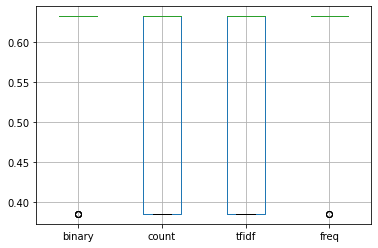

In [37]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding = 'utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close
    return text
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('azerbaijani'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)
# load all docs in a directory
def process_docs(filename, vocab):
    lines = list()
            # load and clean the doc
    line = doc_to_line(filename, vocab)
            # add to list
    line = line.split()
    lines.append(line)
    data = lines[0]
    return (data)
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('negative_words_az.txt', vocab)
    pos = process_docs('positive_words_az.txt', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

def define_model(n_words):
  model = Sequential()
  model.add(Dense(50, input_shape = (n_words,), activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  plot_model(model, to_file = 'output.png', show_shapes = True)
  return model

# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 20
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
    # define network
    model = define_model(n_words)
    # fit network
    model.fit(Xtrain, ytrain, epochs=100, verbose=2)
    # evaluate
    _, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))
  return scores

def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, test_docs, ytrain, ytest = train_test_split(docs,labels, test_size = 0.2)

# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
  # evaluate model on data for mode
  results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
results.boxplot()
pyplot.show()

A box and whisker plot of the results is also presented, summarizing the accuracy distributions
per configuration. We can see that binary achieved the best results with a modest spread and
might be the preferred approach for this dataset.

**Note: Given the stochastic nature of neural networks, your specific results may vary. Consider
running the example a few times.**



## Predicting Sentiment for New Reviews

Finally, we can develop and use a final model to make predictions for new textual reviews. This
is why we wanted the model in the first place. First we will train a final model on all of the
available data. We will use the binary mode for scoring the bag-of-words model that was shown
to give the best results in the previous section.

Predicting the sentiment of new reviews involves following the same steps used to prepare
the test data. Specifically, loading the text, cleaning the document, filtering tokens by the
chosen vocabulary, converting the remaining tokens to a line, encoding it using the Tokenizer,
and making a prediction. We can make a prediction of a class value directly with the fit model
by calling predict() that will return an integer of 0 for a negative review and 1 for a positive
review. All of these steps can be put into a new function called predict sentiment() that
requires the review text, the vocabulary, the tokenizer, and the fit model and returns the
predicted sentiment and an associated percentage or confidence-like output.


In [0]:

  tokens = [w for w in words if w in vocab]
  # convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'

We can now make predictions for new review texts. Below is an example with both a clearly
positive and a clearly negative review using the simple MLP developed above with the frequency
word scoring mode.

In [43]:
text = 'Nicat super oglandirr'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
print('-'*30)
text = 'Virus həyatımıza pis təsir edir'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Nicat super oglandirr]
Sentiment: POSITIVE (86.181%)
------------------------------
Review: [Virus həyatımıza pis təsir edir]
Sentiment: NEGATIVE (90.073%)


In this notebook, we discovered how to develop a bag-of-words model for predicting the sentiment
of reviews.

<hr>

Copyright &copy; 2020 [Nijat Zeynalov](https://github.com/NicatZeynalov). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).